# Credit Scoring Assignment

Coded by: **Jorge Polanco**

In [1]:
# Importing libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
#conda install -c glemaitre imbalanced-learn

In [3]:
# Importing the input tables
path = "C:/Users/jpolancoroque/Desktop/IESEG/02. Second Semester/Credit Scoring"
accepts = pd.read_excel(path+'/ACCEPTS.xlsx')
rejects = pd.read_excel(path+'/REJECTS.xlsx')

In [4]:
X = accepts.iloc[:,:18]
y = accepts['Default_45']
#accepts.head()

## 1) Data Engineering

In this first section, we are exploring the data in order to asses the changes to be done to run the credit scoring model. As you are about to see, there are several aspects to clean before modeling:
* **Fill NAs**: In this case, we are taking the medians as fillers for our NAs.
* **Variable type**: We have to make sure that python is recognizing the variables as categories.
* **Continous variables**: To run a WOE analysis, we have to transform every variable into categorical variable. Each case should take into consideration their particularities. In further lines, we will deeply discuss this matter.

**a) Accepts Database:**

In [5]:
# Inspecting 'accepts' table
accepts.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,Days_late,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio,Default_45
0,250263,1,1,11,5,6,7,1,2,0,1,0,NaN,1.438518,-0.259085,1.781040,0.860269,0.513980,0
1,250290,1,2,6,4,5,1,1,2,1,1,0,1.498183,0.204811,0.383312,1.107163,-0.718249,1.796590,0
2,250249,2,3,11,5,7,7,1,2,1,1,0,-0.241731,-0.852651,-0.732430,1.406664,1.122930,-0.768631,0
3,249516,3,3,10,4,2,4,1,2,0,1,168,NaN,-0.676407,-0.057350,0.957412,-1.702482,0.513980,1
4,249827,1,3,5,2,4,4,1,3,0,1,0,NaN,-0.412042,-0.574648,-0.390342,0.910077,-0.768631,0


In [6]:
accepts.shape

(10000, 19)

In [7]:
# Knowing the data type
accepts.dtypes

ID                       int64
V1                       int64
V2                       int64
V3                       int64
V4                       int64
V5                       int64
V6                       int64
V7                       int64
V8                      object
Has_FICO                 int64
Business_channel         int64
Days_late                int64
FICO_Score             float64
Loan_amount            float64
Monthly_income         float64
Age                    float64
Gearing_coefficient    float64
Max_gearing_ratio      float64
Default_45               int64
dtype: object

In [8]:
# Convert ID into a string
accepts['ID'] = accepts['ID'].astype('str')

In [9]:
# Convert Vs features into category
for i in accepts.iloc[:,1:11].columns:
    accepts[i] = accepts[i].astype('category')

In [10]:
# Convert Vs features into floats
for i in accepts.iloc[:,11:18].columns:
    accepts[i] = accepts[i].astype('float')

In [11]:
# Detecting NAs values
for i in accepts.columns:
    print(i,':',sum(accepts[i].isna()))

ID : 0
V1 : 0
V2 : 0
V3 : 0
V4 : 0
V5 : 0
V6 : 0
V7 : 0
V8 : 0
Has_FICO : 0
Business_channel : 0
Days_late : 0
FICO_Score : 4472
Loan_amount : 0
Monthly_income : 0
Age : 0
Gearing_coefficient : 0
Max_gearing_ratio : 0
Default_45 : 0


In [12]:
# Change the NAs values by medians in the FICO_Score feature
accepts['FICO_Score'] = accepts['FICO_Score'].fillna(accepts['FICO_Score'].median())

In [13]:
# Convert Default_45 features into category
accepts['Default_45'] = accepts['Default_45'].astype('category')

Some variables could present outliers, so it is important to early identify them. Otherwise, some issues would appear in further sections.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


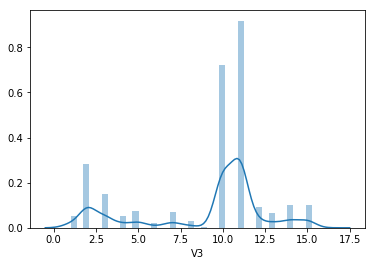

In [14]:
# Analysing V3
sns.distplot(accepts['V3'])

In [15]:
# In order to fix my WOE analysis, I am going to fuse the category 15 and 16
accepts['V3'][accepts['V3'] == 16] = 15

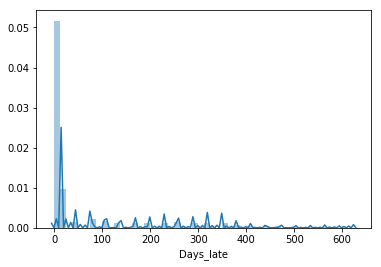

In [16]:
# Analysing Date_Late
sns.distplot(accepts['Days_late'])

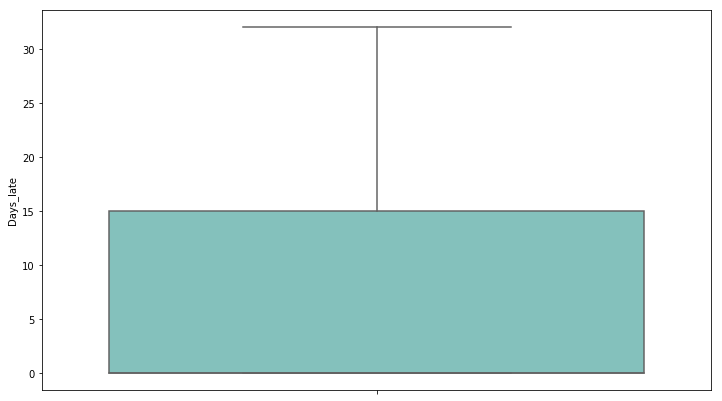

In [17]:
# Analysing Date_Late
ax1 = plt.subplots(1, 1, figsize=(12, 7), sharex=True)
ax1 = sns.boxplot(y='Days_late', data=accepts, palette="GnBu", showfliers = False)

In [18]:
# Here I am creating a dummy variable where more than 45 days late is going to be considered as default
accepts['Days_late'] = accepts['Days_late'].astype('int')

def func(row):
    if row['Days_late'] <= 45:
        return 1
    else:
        return 2

accepts['Days_late_binned'] = accepts.apply(func, axis=1)    
accepts['Days_late_binned'] = accepts['Days_late_binned'].astype('category')

In [19]:
# Binning Max_gearing_ratio
def func(row):
    if row['Max_gearing_ratio'] < 0:
        return 1
    elif row['Max_gearing_ratio'] < 1.7:
        return 2 
    else:
        return 3

accepts['Max_gearing_ratio_binned'] = accepts.apply(func, axis=1)    
accepts['Max_gearing_ratio_binned'] = accepts['Max_gearing_ratio_binned'].astype('category')

In [20]:
accepts.dtypes

ID                            object
V1                          category
V2                          category
V3                          category
V4                          category
V5                          category
V6                          category
V7                          category
V8                          category
Has_FICO                    category
Business_channel            category
Days_late                      int32
FICO_Score                   float64
Loan_amount                  float64
Monthly_income               float64
Age                          float64
Gearing_coefficient          float64
Max_gearing_ratio            float64
Default_45                  category
Days_late_binned            category
Max_gearing_ratio_binned    category
dtype: object

Within this section, we changed some variables in discretionary ways because they demanded it. However, in the rest of the features, we will try to define the bins division and assignation based on decision trees models.

------------------------------------------------------------------------------------------

**b) How did I define the number of bins to convert continuos variables into categorical variables?**

In this section, we are running a cross validation model of decision trees to identify a splitting of my continuos variables. By this, we can get a number of splits with some statistical criterium. We could identify three steps in this process: 1) Run a decission tree model with a established depth, 2) Run a CV decision trees model to indetify the depth with a better performance in terms of AUC, and 3) Run once more time a decision trees model using the optimal depth. By this process, we ill have as result the number of bins and its division.

In [21]:
# Splitting the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(accepts.iloc[:,11:],accepts['Default_45'] , test_size = 0.3)

***Binned Age***:

In [22]:
tree_model = DecisionTreeClassifier(max_depth=10)
tree_model.fit(X_train['Age'].to_frame(), X_train['Default_45'])
X_train['Age_tree']=tree_model.predict_proba(X_train['Age'].to_frame())[:,1] 

In [23]:
# Age_tree

score_ls = []     # here I will store the roc auc
score_std_ls = [] # here I will store the standard deviation of the roc_auc

for tree_depth in list(range(1,11)):
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)
    
    scores = cross_val_score(tree_model, X_train['Age_tree'].to_frame(),       
    y_train, cv=3, scoring='roc_auc')   
    
    score_ls.append(np.mean(scores))
    
    score_std_ls.append(np.std(scores))
    
temp = pd.concat([pd.Series(list(range(1,11))), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)
temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
print(temp)

   depth  roc_auc_mean  roc_auc_std
0      1      0.608464     0.003856
1      2      0.642081     0.006483
2      3      0.652989     0.004981
3      4      0.651336     0.007169
4      5      0.652153     0.004174
5      6      0.647373     0.005939
6      7      0.646956     0.006345
7      8      0.646163     0.007140
8      9      0.646376     0.006902
9     10      0.646381     0.006896


In [24]:
tree_model_1 = DecisionTreeClassifier(max_depth=3)
tree_model_1.fit(X_train['Age'].to_frame(), X_train['Default_45'])
X_train['Age_tree']=tree_model_1.predict_proba(X_train['Age'].to_frame())[:,1] 

In [25]:
X_train['Age_tree'].nunique()

8

In [26]:
accepts['Age_binned'] = tree_model_1.predict_proba(accepts['Age'].to_frame())[:,1]
accepts['Age_binned'] = accepts['Age_binned'].astype('category')

***Binned Days_late***:

In [27]:
tree_model = DecisionTreeClassifier(max_depth=10)
tree_model.fit(X_train['Days_late'].to_frame(), X_train['Default_45'])
X_train['Days_late_tree']=tree_model.predict_proba(X_train['Days_late'].to_frame())[:,1] 

In [28]:
# Days_late_tree

score_ls = []     # here I will store the roc auc
score_std_ls = [] # here I will store the standard deviation of the roc_auc

for tree_depth in list(range(1,11)):
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)
    
    scores = cross_val_score(tree_model, X_train['Days_late_tree'].to_frame(),       
    y_train, cv=3, scoring='roc_auc')   
    
    score_ls.append(np.mean(scores))
    
    score_std_ls.append(np.std(scores))
    
temp = pd.concat([pd.Series(list(range(1,11))), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)
temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
print(temp)

   depth  roc_auc_mean  roc_auc_std
0      1           1.0          0.0
1      2           1.0          0.0
2      3           1.0          0.0
3      4           1.0          0.0
4      5           1.0          0.0
5      6           1.0          0.0
6      7           1.0          0.0
7      8           1.0          0.0
8      9           1.0          0.0
9     10           1.0          0.0


This is happening because the data distirbution. For this reason, the splitting is going to be 'by hand'.

In [29]:
#tree_model = DecisionTreeClassifier(max_depth=2)
#tree_model.fit(X_train['Days_late'].to_frame(), X_train['Default_45'])
#X_train['Days_late_tree']=tree_model.predict_proba(X_train['Days_late'].to_frame())[:,1] 

In [30]:
#X_train['Days_late_tree'].nunique()

In [31]:
#accepts['Days_late_binned'] = tree_model.predict_proba(accepts['Days_late'].to_frame())[:,1]
#accepts['Days_late_binned'] = accepts['Days_late_binned'].astype('category')

***Binned FICO_Score:***:

In [32]:
tree_model = DecisionTreeClassifier(max_depth=10)
tree_model.fit(X_train['FICO_Score'].to_frame(), X_train['Default_45'])
X_train['FICO_Score_tree']=tree_model.predict_proba(X_train['FICO_Score'].to_frame())[:,1] 

In [33]:
# FICO_Score_tree

score_ls = []     # here I will store the roc auc
score_std_ls = [] # here I will store the standard deviation of the roc_auc

for tree_depth in list(range(1,11)):
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)
    
    scores = cross_val_score(tree_model, X_train['FICO_Score_tree'].to_frame(),       
    y_train, cv=3, scoring='roc_auc')   
    
    score_ls.append(np.mean(scores))
    
    score_std_ls.append(np.std(scores))
    
temp = pd.concat([pd.Series(list(range(1,11))), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)
temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
print(temp)

   depth  roc_auc_mean  roc_auc_std
0      1      0.618244     0.014523
1      2      0.690423     0.006344
2      3      0.706112     0.006244
3      4      0.707069     0.008861
4      5      0.705149     0.008267
5      6      0.701199     0.011069
6      7      0.696981     0.011358
7      8      0.696594     0.011964
8      9      0.696204     0.011817
9     10      0.696279     0.011858


In [34]:
tree_model_2 = DecisionTreeClassifier(max_depth=2)
tree_model_2.fit(X_train['FICO_Score'].to_frame(), X_train['Default_45'])
X_train['FICO_Score_tree']=tree_model_2.predict_proba(X_train['FICO_Score'].to_frame())[:,1] 

In [35]:
X_train['FICO_Score_tree'].nunique()

4

In [36]:
accepts['FICO_Score_binned'] = tree_model_2.predict_proba(accepts['FICO_Score'].to_frame())[:,1]
accepts['FICO_Score_binned'] = accepts['FICO_Score_binned'].astype('category')

***Binned Loan_amount:***:

In [37]:
tree_model = DecisionTreeClassifier(max_depth=10)
tree_model.fit(X_train['Loan_amount'].to_frame(), X_train['Default_45'])
X_train['Loan_amount_tree']=tree_model.predict_proba(X_train['Loan_amount'].to_frame())[:,1] 

In [38]:
# Loan_amount_tree

score_ls = []     # here I will store the roc auc
score_std_ls = [] # here I will store the standard deviation of the roc_auc
for tree_depth in list(range(1,11)):
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)
    
    scores = cross_val_score(tree_model, X_train['Loan_amount_tree'].to_frame(),       
    y_train, cv=3, scoring='roc_auc')   
    
    score_ls.append(np.mean(scores))
    
    score_std_ls.append(np.std(scores))
    
temp = pd.concat([pd.Series(list(range(1,11))), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)
temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
print(temp)

   depth  roc_auc_mean  roc_auc_std
0      1      0.553887     0.000685
1      2      0.567796     0.003072
2      3      0.586514     0.004446
3      4      0.590732     0.005620
4      5      0.589842     0.011997
5      6      0.586094     0.009358
6      7      0.584120     0.007946
7      8      0.583497     0.007130
8      9      0.583253     0.006794
9     10      0.583253     0.006794


In [39]:
tree_model_3 = DecisionTreeClassifier(max_depth=1)
tree_model_3.fit(X_train['Loan_amount'].to_frame(), X_train['Default_45'])
X_train['Loan_amount_tree']=tree_model_3.predict_proba(X_train['Loan_amount'].to_frame())[:,1] 

In [40]:
X_train['Loan_amount_tree'].nunique()

2

In [41]:
accepts['Loan_amount_binned'] = tree_model_3.predict_proba(accepts['Loan_amount'].to_frame())[:,1]
accepts['Loan_amount_binned'] = accepts['Loan_amount_binned'].astype('category')

***Binned Monthly_income:***:

In [42]:
tree_model = DecisionTreeClassifier(max_depth=10)
tree_model.fit(X_train['Monthly_income'].to_frame(), X_train['Default_45'])
X_train['Monthly_income_tree']=tree_model.predict_proba(X_train['Monthly_income'].to_frame())[:,1] 

In [43]:
# Monthly_income_tree

score_ls = []     # here I will store the roc auc
score_std_ls = [] # here I will store the standard deviation of the roc_auc

for tree_depth in list(range(1,11)):
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)
    
    scores = cross_val_score(tree_model, X_train['Monthly_income_tree'].to_frame(),       
    y_train, cv=3, scoring='roc_auc')   
    
    score_ls.append(np.mean(scores))
    
    score_std_ls.append(np.std(scores))
    
temp = pd.concat([pd.Series(list(range(1,11))), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)
temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
print(temp)

   depth  roc_auc_mean  roc_auc_std
0      1      0.533529     0.024532
1      2      0.582710     0.008822
2      3      0.612870     0.010653
3      4      0.626396     0.012414
4      5      0.626825     0.013633
5      6      0.622388     0.011894
6      7      0.616670     0.013139
7      8      0.615511     0.012519
8      9      0.614877     0.011263
9     10      0.614844     0.011267


In [44]:
tree_model_4 = DecisionTreeClassifier(max_depth=2)
tree_model_4.fit(X_train['Monthly_income'].to_frame(), X_train['Default_45'])
X_train['Monthly_income_tree']=tree_model_4.predict_proba(X_train['Monthly_income'].to_frame())[:,1] 

In [45]:
X_train['Monthly_income_tree'].nunique()

4

In [46]:
accepts['Monthly_income_binned'] = tree_model_4.predict_proba(accepts['Monthly_income'].to_frame())[:,1]
accepts['Monthly_income_binned'] = accepts['Monthly_income_binned'].astype('category')

***Binned Gearing_coefficient:***

In [47]:
tree_model = DecisionTreeClassifier(max_depth=10)
tree_model.fit(X_train['Gearing_coefficient'].to_frame(), X_train['Default_45'])
X_train['Gearing_coefficient_tree']=tree_model.predict_proba(X_train['Gearing_coefficient'].to_frame())[:,1] 

In [48]:
# Gearing_coefficient_tree

score_ls = []     # here I will store the roc auc
score_std_ls = [] # here I will store the standard deviation of the roc_auc

for tree_depth in list(range(1,11)):
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)
    
    scores = cross_val_score(tree_model, X_train['Gearing_coefficient_tree'].to_frame(),       
    y_train, cv=3, scoring='roc_auc')   
    
    score_ls.append(np.mean(scores))
    
    score_std_ls.append(np.std(scores))
    
temp = pd.concat([pd.Series(list(range(1,11))), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)
temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
print(temp)

   depth  roc_auc_mean  roc_auc_std
0      1      0.523291     0.009588
1      2      0.541738     0.008718
2      3      0.568581     0.002081
3      4      0.577253     0.002803
4      5      0.568243     0.007075
5      6      0.567064     0.009103
6      7      0.565873     0.007799
7      8      0.565295     0.007639
8      9      0.565226     0.007730
9     10      0.565226     0.007730


In [49]:
tree_model_5 = DecisionTreeClassifier(max_depth=1)
tree_model_5.fit(X_train['Gearing_coefficient'].to_frame(), X_train['Default_45'])
X_train['Gearing_coefficient_tree']=tree_model_5.predict_proba(X_train['Gearing_coefficient'].to_frame())[:,1] 

In [50]:
X_train['Gearing_coefficient_tree'].nunique()

2

In [51]:
accepts['Gearing_coefficient_binned'] = tree_model_5.predict_proba(accepts['Gearing_coefficient'].to_frame())[:,1]
accepts['Gearing_coefficient_binned'] = accepts['Gearing_coefficient_binned'].astype('category')

In [52]:
accepts.nunique()

ID                            10000
V1                                5
V2                                6
V3                               15
V4                                6
V5                                7
V6                                7
V7                                3
V8                                5
Has_FICO                          2
Business_channel                  3
Days_late                        55
FICO_Score                      397
Loan_amount                     776
Monthly_income                 2317
Age                              49
Gearing_coefficient            4583
Max_gearing_ratio                 3
Default_45                        2
Days_late_binned                  2
Max_gearing_ratio_binned          3
Age_binned                        8
FICO_Score_binned                 4
Loan_amount_binned                2
Monthly_income_binned             4
Gearing_coefficient_binned        2
dtype: int64

Righ now, we are presenting the final decisions regarding the splitting. Nevertheless, some issues presented in the next section suggested to do some changes.

------------------------------------------------------------------------------------------

**c) Final 'Accepts' table:**

Now, we have a table with only categorical variables.

In [53]:
# Final table 
a1 = accepts.iloc[:,:11]
a2 = accepts.iloc[:,19:]
a3 = pd.DataFrame(accepts['Default_45'])

frames = [a1,a2,a3]
a_db = pd.concat(frames,axis=1)
a_db.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,Days_late_binned,Max_gearing_ratio_binned,Age_binned,FICO_Score_binned,Loan_amount_binned,Monthly_income_binned,Gearing_coefficient_binned,Default_45
0,250263,1,1,11,5,6,7,1,2,0,1,1,2,0.123350,0.242116,0.241163,0.260480,0.221184,0
1,250290,1,2,6,4,5,1,1,2,1,1,1,3,0.123350,0.065341,0.241163,0.260480,0.221184,0
2,250249,2,3,11,5,7,7,1,2,1,1,1,1,0.123350,0.242116,0.241163,0.139200,0.269817,0
3,249516,3,3,10,4,2,4,1,2,0,1,2,2,0.123350,0.242116,0.241163,0.260480,0.221184,1
4,249827,1,3,5,2,4,4,1,3,0,1,1,1,0.276257,0.242116,0.241163,0.206481,0.221184,0


In [54]:
# Fixing a couple of bugs
a_db['Age_binned'] = a_db['Age_binned'].astype('category')
a_db['Max_gearing_ratio_binned'] = a_db['Max_gearing_ratio_binned'].astype('category')

In [55]:
a_db.dtypes

ID                              object
V1                            category
V2                            category
V3                            category
V4                            category
V5                            category
V6                            category
V7                            category
V8                            category
Has_FICO                      category
Business_channel              category
Days_late_binned              category
Max_gearing_ratio_binned      category
Age_binned                    category
FICO_Score_binned             category
Loan_amount_binned            category
Monthly_income_binned         category
Gearing_coefficient_binned    category
Default_45                    category
dtype: object

In [56]:
#a_db.to_csv('C:/Users/jpolancoroque/Desktop/IESEG/02. Second Semester/Credit Scoring/a_db.csv')

------------------------------------------------------------------------------------------

**d) Data Transformation — Weight of Evidence Method:**

For each variable, we are going to run the following processes: 1) pivot a table to have the counting of the categorical variables in each situation of the target variable, 2) build the WOE analysis table. The latter will help us to create the WOE metric, which will be used in the scoring model, and to do a feature selection. In order to run the feature selection, we have to buld the Information Value metric, which is derived from the WOE's metrics. According to the literature, anything below IV=0.02 should be discarded.

***V1 WOE:***

In [57]:
# Pivoting the V1
v1_p = a_db[['ID','V1','Default_45']]
V1_pivoted = v1_p.pivot_table(v1_p,index= ['V1'],columns='Default_45', aggfunc='count',fill_value=0)
#V1_pivoted = pd.DataFrame(V1_pivoted.unstack()).reset_index().rename(columns={"Default_45": "Target",0: "Counting"})
#V1_pivoted = V1_pivoted.drop(['level_0','V1'],axis=1)
V1_pivoted

ID      
Default_45     0     1
V1                    
1           4728  1055
2            415    87
3           1857  1011
4            631   208
5              5     3

In [58]:
# Building V1 WOE table
v1_good = V1_pivoted.ID[0]
v1_bad = V1_pivoted.ID[1]

# Extracting the dictionary
V1_Segments = dict(Counter(a_db['V1']))

# Columns counting 
V1 = pd.DataFrame.from_dict(V1_Segments, orient='index').reset_index().rename(columns={"index": "V1_Segments",0: "Counting"}).set_index('V1_Segments')

frames = [v1_good,v1_bad,V1]

# Bad/Good Countings
V1['Bad'] = v1_bad
V1['Good'] = v1_good

# Calculate WOE
V1['Total_Distri'] = V1['Counting']/sum(V1['Counting'])
V1['Bad_Distri'] = V1['Bad']/sum(V1['Bad'])
V1['Good_Distri'] = V1['Good']/sum(V1['Good'])
V1['WOE'] = np.log(V1['Good_Distri'] / V1['Bad_Distri'])
V1['WOE%'] = V1['WOE'] * 100

V1

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
V1_Segments,,,,,,,,
1,5783,1055,4728,0.5783,0.446277,0.619172,0.327443,32.744271
2,502,87,415,0.0502,0.036802,0.054348,0.389852,38.985160
3,2868,1011,1857,0.2868,0.427665,0.243190,-0.564496,-56.449646
4,839,208,631,0.0839,0.087986,0.082635,-0.062751,-6.275102
5,8,3,5,0.0008,0.001269,0.000655,-0.661693,-66.169318


In [59]:
# Information Value
IV_V1 = sum((V1['Good_Distri']-V1['Bad_Distri'])*V1['WOE'])
IV_V1

0.1683310547565218

Considering this level of Information Value, we can tell V1 feature has a medium predictive power.

***V2 WOE:***

In [60]:
# Pivoting the V2
V2_p = a_db[['ID','V2','Default_45']]
V2_pivoted = V2_p.pivot_table(V2_p,index= ['V2'],columns='Default_45', aggfunc='count',fill_value=0)
#V2_pivoted = pd.DataFrame(V2_pivoted.unstack()).reset_index().rename(columns={"Default_45": "Target",0: "Counting"})
#V2_pivoted = V2_pivoted.drop(['level_0','V2'],axis=1)
V2_pivoted

ID     
Default_45     0    1
V2                   
1            890  168
2            250   43
3           2862  984
4           1845  426
5           1764  740
6             25    3

In [61]:
# Building V2 WOE table
V2_good = V2_pivoted.ID[0]
V2_bad = V2_pivoted.ID[1]

# Extracting the dictionary
V2_Segments = dict(Counter(a_db['V2']))

# Columns counting 
V2 = pd.DataFrame.from_dict(V2_Segments, orient='index').reset_index().rename(columns={"index": "V2_Segments",0: "Counting"}).set_index('V2_Segments')

frames = [V2_good,V2_bad,V2]

# Bad/Good Countings
V2['Bad'] = V2_bad
V2['Good'] = V2_good

# Calculate WOE
V2['Total_Distri'] = V2['Counting']/sum(V2['Counting'])
V2['Bad_Distri'] = V2['Bad']/sum(V2['Bad'])
V2['Good_Distri'] = V2['Good']/sum(V2['Good'])
V2['WOE'] = np.log(V2['Good_Distri'] / V2['Bad_Distri'])
V2['WOE%'] = V2['WOE'] * 100

V2

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
V2_Segments,,,,,,,,
1,1058,168,890,0.1058,0.071066,0.116553,0.494739,49.473868
2,293,43,250,0.0293,0.018190,0.032740,0.587742,58.774200
3,3846,984,2862,0.3846,0.416244,0.374804,-0.104869,-10.486874
4,2271,426,1845,0.2271,0.180203,0.241619,0.293276,29.327640
5,2504,740,1764,0.2504,0.313029,0.231011,-0.303830,-30.382976
6,28,3,25,0.0028,0.001269,0.003274,0.947745,94.774473


In [62]:
# Information Value
IV_V2 = sum((V2['Good_Distri']-V2['Bad_Distri'])*V2['WOE'])
IV_V2

0.08023311480406797

Considering this level of Information Value, we can tell V2 feature has a weak predictive power.

***V3 WOE:***

In [63]:
# Pivoting the V3
V3_p = a_db[['ID','V3','Default_45']]
V3_pivoted = V3_p.pivot_table(V3_p,index= ['V3'],columns='Default_45', aggfunc='count',fill_value=0)
V3_pivoted

ID     
Default_45     0    1
V3                   
1            156   35
2            764  264
3            365  184
4            151   42
5            250   27
6             51   19
7            221   41
8             77   30
9             13    3
10          1841  800
11          2757  601
12           295   43
13           179   62
14           242  122
15           274   91

In [64]:
# Building V3 WOE table
V3_good = V3_pivoted.ID[0]
V3_bad = V3_pivoted.ID[1]

# Extracting the dictionary
V3_Segments = dict(Counter(a_db['V3']))

# Columns counting 
V3 = pd.DataFrame.from_dict(V3_Segments, orient='index').reset_index().rename(columns={"index": "V3_Segments",0: "Counting"}).set_index('V3_Segments')

frames = [V3_good,V3_bad,V3]

# Bad/Good Countings
V3['Bad'] = V3_bad
V3['Good'] = V3_good

# Calculate WOE
V3['Total_Distri'] = V3['Counting']/sum(V3['Counting'])
V3['Bad_Distri'] = V3['Bad']/sum(V3['Bad'])
V3['Good_Distri'] = V3['Good']/sum(V3['Good'])
V3['WOE'] = np.log(V3['Good_Distri'] / V3['Bad_Distri'])
V3['WOE%'] = V3['WOE'] * 100

V3

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
V3_Segments,,,,,,,,
11,3358,601,2757,0.3358,0.254230,0.361053,0.350785,35.078467
6,70,19,51,0.0070,0.008037,0.006679,-0.185132,-18.513215
10,2641,800,1841,0.2641,0.338409,0.241095,-0.339066,-33.906635
5,277,27,250,0.0277,0.011421,0.032740,1.053105,105.310525
12,338,43,295,0.0338,0.018190,0.038633,0.753256,75.325643
14,364,122,242,0.0364,0.051607,0.031692,-0.487602,-48.760212
15,365,91,274,0.0365,0.038494,0.035883,-0.070250,-7.025021
3,549,184,365,0.0549,0.077834,0.047800,-0.487557,-48.755721
2,1028,264,764,0.1028,0.111675,0.100052,-0.109900,-10.990012


In [65]:
# Information Value
IV_V3 = sum((V3['Good_Distri']-V3['Bad_Distri'])*V3['WOE'])
IV_V3

0.14338840003232295

Considering this level of Information Value, we can tell V3 feature has a medium predictive power.

***V4 WOE:***

In [66]:
# Pivoting the V4
V4_p = a_db[['ID','V4','Default_45']]
V4_pivoted = V4_p.pivot_table(V4_p,index= ['V4'],columns='Default_45', aggfunc='count',fill_value=0)
V4_pivoted

ID      
Default_45     0     1
V4                    
1           1078   295
2           1438   507
3            692   258
4           2568  1046
5           1858   257
6              2     1

In [67]:
# Building V4 WOE table
V4_good = V4_pivoted.ID[0]
V4_bad = V4_pivoted.ID[1]

# Extracting the dictionary
V4_Segments = dict(Counter(a_db['V4']))

# Columns counting 
V4 = pd.DataFrame.from_dict(V4_Segments, orient='index').reset_index().rename(columns={"index": "V4_Segments",0: "Counting"}).set_index('V4_Segments')

frames = [V4_good,V4_bad,V4]

# Bad/Good Countings
V4['Bad'] = V4_bad
V4['Good'] = V4_good

# Calculate WOE
V4['Total_Distri'] = V4['Counting']/sum(V4['Counting'])
V4['Bad_Distri'] = V4['Bad']/sum(V4['Bad'])
V4['Good_Distri'] = V4['Good']/sum(V4['Good'])
V4['WOE'] = np.log(V4['Good_Distri'] / V4['Bad_Distri'])
V4['WOE%'] = V4['WOE'] * 100

V4

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
V4_Segments,,,,,,,,
5,2115,257,1858,0.2115,0.108714,0.243321,0.805661,80.566103
4,3614,1046,2568,0.3614,0.442470,0.336302,-0.274365,-27.436479
2,1945,507,1438,0.1945,0.214467,0.188318,-0.130021,-13.002127
3,950,258,692,0.0950,0.109137,0.090623,-0.185892,-18.589244
1,1373,295,1078,0.1373,0.124788,0.141173,0.123369,12.336859
6,3,1,2,0.0003,0.000423,0.000262,-0.479372,-47.937163


In [68]:
# Information Value
IV_V4 = sum((V4['Good_Distri']-V4['Bad_Distri'])*V4['WOE'])
IV_V4

0.14651663349079613

Considering this level of Information Value, we can tell V4 feature has a medium predictive power.

***V5 WOE:***

In [69]:
# Pivoting the V5
V5_p = a_db[['ID','V5','Default_45']]
V5_pivoted = V5_p.pivot_table(V5_p,index= ['V5'],columns='Default_45', aggfunc='count',fill_value=0)
V5_pivoted

ID     
Default_45     0    1
V5                   
1            585  367
2           1371  784
3           1255  450
4           1192  269
5            715  147
6            713   99
7           1805  248

In [70]:
# Building V5 WOE table
V5_good = V5_pivoted.ID[0]
V5_bad = V5_pivoted.ID[1]

# Extracting the dictionary
V5_Segments = dict(Counter(a_db['V5']))

# Columns counting 
V5 = pd.DataFrame.from_dict(V5_Segments, orient='index').reset_index().rename(columns={"index": "V5_Segments",0: "Counting"}).set_index('V5_Segments')

frames = [V5_good,V5_bad,V5]

# Bad/Good Countings
V5['Bad'] = V5_bad
V5['Good'] = V5_good

# Calculate WOE
V5['Total_Distri'] = V5['Counting']/sum(V5['Counting'])
V5['Bad_Distri'] = V5['Bad']/sum(V5['Bad'])
V5['Good_Distri'] = V5['Good']/sum(V5['Good'])
V5['WOE'] = np.log(V5['Good_Distri'] / V5['Bad_Distri'])
V5['WOE%'] = V5['WOE'] * 100

V5

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
V5_Segments,,,,,,,,
6,812,99,713,0.0812,0.041878,0.093373,0.801843,80.184276
5,862,147,715,0.0862,0.062183,0.093635,0.409331,40.933115
7,2053,248,1805,0.2053,0.104907,0.236380,0.812368,81.236832
2,2155,784,1371,0.2155,0.331641,0.179544,-0.613632,-61.363215
4,1461,269,1192,0.1461,0.113790,0.156103,0.316158,31.615766
3,1705,450,1255,0.1705,0.190355,0.164353,-0.146876,-14.687554
1,952,367,585,0.0952,0.155245,0.076611,-0.706269,-70.626881


In [71]:
# Information Value
IV_V5 = sum((V5['Good_Distri']-V5['Bad_Distri'])*V5['WOE'])
IV_V5

0.3270357753289542

Considering this level of Information Value, we can tell V5 feature has a strong predictive power.

***V6 WOE:***

In [72]:
# Pivoting the V6
V6_p = a_db[['ID','V6','Default_45']]
V6_pivoted = V6_p.pivot_table(V6_p,index= ['V6'],columns='Default_45', aggfunc='count',fill_value=0)
V6_pivoted

ID      
Default_45     0     1
V6                    
1            207    38
2            221    45
3            295    43
4           2384   710
5           2653  1267
6             26    17
7           1850   244

In [73]:
# Building V6 WOE table
V6_good = V6_pivoted.ID[0]
V6_bad = V6_pivoted.ID[1]

# Extracting the dictionary
V6_Segments = dict(Counter(a_db['V6']))

# Columns counting 
V6 = pd.DataFrame.from_dict(V6_Segments, orient='index').reset_index().rename(columns={"index": "V6_Segments",0: "Counting"}).set_index('V6_Segments')

frames = [V6_good,V6_bad,V6]

# Bad/Good Countings
V6['Bad'] = V6_bad
V6['Good'] = V6_good

# Calculate WOE
V6['Total_Distri'] = V6['Counting']/sum(V6['Counting'])
V6['Bad_Distri'] = V6['Bad']/sum(V6['Bad'])
V6['Good_Distri'] = V6['Good']/sum(V6['Good'])
V6['WOE'] = np.log(V6['Good_Distri'] / V6['Bad_Distri'])
V6['WOE%'] = V6['WOE'] * 100

V6

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
V6_Segments,,,,,,,,
7,2094,244,1850,0.2094,0.103215,0.242273,0.853254,85.325389
1,245,38,207,0.0245,0.016074,0.027108,0.522614,52.261383
4,3094,710,2384,0.3094,0.300338,0.312205,0.038751,3.875125
5,3920,1267,2653,0.3920,0.535956,0.347433,-0.433480,-43.347963
6,43,17,26,0.0043,0.007191,0.003405,-0.747636,-74.763561
2,266,45,221,0.0266,0.019036,0.028942,0.418981,41.898141
3,338,43,295,0.0338,0.018190,0.038633,0.753256,75.325643


In [74]:
# Information Value
IV_V6 = sum((V6['Good_Distri']-V6['Bad_Distri'])*V6['WOE'])
IV_V6

0.22897976718361462

Considering this level of Information Value, we can tell V6 feature has a medium predictive power.

***V7 WOE:***

In [75]:
# Pivoting the V7
V7_p = a_db[['ID','V7','Default_45']]
V7_pivoted = V7_p.pivot_table(V7_p,index= ['V7'],columns='Default_45', aggfunc='count',fill_value=0)
V7_pivoted

ID      
Default_45     0     1
V7                    
1           4945  1161
2            140    76
3           2551  1127

In [76]:
# Building V7 WOE table
V7_good = V7_pivoted.ID[0]
V7_bad = V7_pivoted.ID[1]

# Extracting the dictionary
V7_Segments = dict(Counter(a_db['V7']))

# Columns counting 
V7 = pd.DataFrame.from_dict(V7_Segments, orient='index').reset_index().rename(columns={"index": "V7_Segments",0: "Counting"}).set_index('V7_Segments')

frames = [V7_good,V7_bad,V7]

# Bad/Good Countings
V7['Bad'] = V7_bad
V7['Good'] = V7_good

# Calculate WOE
V7['Total_Distri'] = V7['Counting']/sum(V7['Counting'])
V7['Bad_Distri'] = V7['Bad']/sum(V7['Bad'])
V7['Good_Distri'] = V7['Good']/sum(V7['Good'])
V7['WOE'] = np.log(V7['Good_Distri'] / V7['Bad_Distri'])
V7['WOE%'] = V7['WOE'] * 100

V7

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
V7_Segments,,,,,,,,
1,6106,1161,4945,0.6106,0.491117,0.647590,0.276576,27.657646
3,3678,1127,2551,0.3678,0.476734,0.334075,-0.355593,-35.559260
2,216,76,140,0.0216,0.032149,0.018334,-0.561610,-56.160972


In [77]:
# Information Value
IV_V7 = sum((V7['Good_Distri']-V7['Bad_Distri'])*V7['WOE'])
IV_V7

0.10176383823797963

Considering this level of Information Value, we can tell V7 feature has a medium predictive power.

***V8 WOE:***

In [78]:
# Pivoting the V8
V8_p = a_db[['ID','V8','Default_45']]
V8_pivoted = V8_p.pivot_table(V8_p,index= ['V8'],columns='Default_45', aggfunc='count',fill_value=0)
V8_pivoted

ID      
Default_45     0     1
V8                    
1           2578  1125
2           3080   707
3           1191   295
4            654   188
>4           133    49

In [79]:
# Building V8 WOE table
V8_good = V8_pivoted.ID[0]
V8_bad = V8_pivoted.ID[1]

# Extracting the dictionary
V8_Segments = dict(Counter(a_db['V8']))

# Columns counting 
V8 = pd.DataFrame.from_dict(V8_Segments, orient='index').reset_index().rename(columns={"index": "V8_Segments",0: "Counting"}).set_index('V8_Segments')

frames = [V8_good,V8_bad,V8]

# Bad/Good Countings
V8['Bad'] = V8_bad
V8['Good'] = V8_good

# Calculate WOE
V8['Total_Distri'] = V8['Counting']/sum(V8['Counting'])
V8['Bad_Distri'] = V8['Bad']/sum(V8['Bad'])
V8['Good_Distri'] = V8['Good']/sum(V8['Good'])
V8['WOE'] = np.log(V8['Good_Distri'] / V8['Bad_Distri'])
V8['WOE%'] = V8['WOE'] * 100

V8

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
V8_Segments,,,,,,,,
2,3787,707,3080,0.3787,0.299069,0.403353,0.299135,29.913540
3,1486,295,1191,0.1486,0.124788,0.155972,0.223054,22.305441
4,842,188,654,0.0842,0.079526,0.085647,0.074147,7.414658
1,3703,1125,2578,0.3703,0.475888,0.337611,-0.343288,-34.328794
>4,182,49,133,0.0182,0.020728,0.017417,-0.173990,-17.398998


In [80]:
# Information Value
IV_V8 = sum((V8['Good_Distri']-V8['Bad_Distri'])*V8['WOE'])
IV_V8

0.08664892225131007

Considering this level of Information Value, we can tell V8 feature has a weak predictive power.

***Has_FICO WOE:***

In [81]:
# Pivoting the HAS_ICO
HAS_FICO_p = a_db[['ID','Has_FICO','Default_45']]
HAS_FICO_pivoted = HAS_FICO_p.pivot_table(HAS_FICO_p,index= ['Has_FICO'],columns='Default_45', aggfunc='count',fill_value=0)
HAS_FICO_pivoted

ID      
Default_45     0     1
Has_FICO              
0           3320  1152
1           4316  1212

In [82]:
# Building HAS_FICO WOE table
HAS_FICO_good = HAS_FICO_pivoted.ID[0]
HAS_FICO_bad = HAS_FICO_pivoted.ID[1]

# Extracting the dictionary
HAS_FICO_Segments = dict(Counter(a_db['Has_FICO']))

# Columns counting 
HAS_FICO = pd.DataFrame.from_dict(HAS_FICO_Segments, orient='index').reset_index().rename(columns={"index": "Has_FICO_Segments",0: "Counting"}).set_index('Has_FICO_Segments')

frames = [HAS_FICO_good,HAS_FICO_bad,HAS_FICO]

# Bad/Good Countings
HAS_FICO['Bad'] = HAS_FICO_bad
HAS_FICO['Good'] = HAS_FICO_good

# Calculate WOE
HAS_FICO['Total_Distri'] = HAS_FICO['Counting']/sum(HAS_FICO['Counting'])
HAS_FICO['Bad_Distri'] = HAS_FICO['Bad']/sum(HAS_FICO['Bad'])
HAS_FICO['Good_Distri'] = HAS_FICO['Good']/sum(HAS_FICO['Good'])
HAS_FICO['WOE'] = np.log(HAS_FICO['Good_Distri'] / HAS_FICO['Bad_Distri'])
HAS_FICO['WOE%'] = HAS_FICO['WOE'] * 100

HAS_FICO

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
Has_FICO_Segments,,,,,,,,
0,4472,1152,3320,0.4472,0.48731,0.434783,-0.114054,-11.405359
1,5528,1212,4316,0.5528,0.51269,0.565217,0.097538,9.753835


In [83]:
# Information Value
IV_HAS_FICO = sum((HAS_FICO['Good_Distri']-HAS_FICO['Bad_Distri'])*HAS_FICO['WOE'])
IV_HAS_FICO

0.011114297396686859

Considering this level of Information Value, we can tell Has_FICO feature is not useful for prediction.

***Business_channel WOE:***

In [84]:
# Pivoting the BUSINESS_CHANNEL
BUSINESS_CHANNEL_p = a_db[['ID','Business_channel','Default_45']]
BUSINESS_CHANNEL_pivoted = BUSINESS_CHANNEL_p.pivot_table(BUSINESS_CHANNEL_p,index= ['Business_channel'],columns='Default_45', aggfunc='count',fill_value=0)
BUSINESS_CHANNEL_pivoted

ID      
Default_45           0     1
Business_channel            
1                 5488  1424
2                 1287   857
3                  861    83

In [85]:
# Building BUSINESS_CHANNEL WOE table
BUSINESS_CHANNEL_good = BUSINESS_CHANNEL_pivoted.ID[0]
BUSINESS_CHANNEL_bad = BUSINESS_CHANNEL_pivoted.ID[1]

# Extracting the dictionary
BUSINESS_CHANNEL_Segments = dict(Counter(a_db['Business_channel']))

# Columns counting 
BUSINESS_CHANNEL = pd.DataFrame.from_dict(BUSINESS_CHANNEL_Segments, orient='index').reset_index().rename(columns={"index": "BUSINESS_CHANNEL_Segments",0: "Counting"}).set_index('BUSINESS_CHANNEL_Segments')

frames = [BUSINESS_CHANNEL_good,BUSINESS_CHANNEL_bad,BUSINESS_CHANNEL]

# Bad/Good Countings
BUSINESS_CHANNEL['Bad'] = BUSINESS_CHANNEL_bad
BUSINESS_CHANNEL['Good'] = BUSINESS_CHANNEL_good

# Calculate WOE
BUSINESS_CHANNEL['Total_Distri'] = BUSINESS_CHANNEL['Counting']/sum(BUSINESS_CHANNEL['Counting'])
BUSINESS_CHANNEL['Bad_Distri'] = BUSINESS_CHANNEL['Bad']/sum(BUSINESS_CHANNEL['Bad'])
BUSINESS_CHANNEL['Good_Distri'] = BUSINESS_CHANNEL['Good']/sum(BUSINESS_CHANNEL['Good'])
BUSINESS_CHANNEL['WOE'] = np.log(BUSINESS_CHANNEL['Good_Distri'] / BUSINESS_CHANNEL['Bad_Distri'])
BUSINESS_CHANNEL['WOE%'] = BUSINESS_CHANNEL['WOE'] * 100

BUSINESS_CHANNEL

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
BUSINESS_CHANNEL_Segments,,,,,,,,
1,6912,1424,5488,0.6912,0.602369,0.718701,0.176575,17.657527
2,2144,857,1287,0.2144,0.362521,0.168544,-0.765888,-76.588752
3,944,83,861,0.0944,0.035110,0.112755,1.166735,116.673509


In [86]:
# Information Value
IV_BUSINESS_CHANNEL = sum((BUSINESS_CHANNEL['Good_Distri']-BUSINESS_CHANNEL['Bad_Distri'])*BUSINESS_CHANNEL['WOE'])
IV_BUSINESS_CHANNEL

0.2596978326972122

Considering this level of Information Value, we can tell Business_channel feature has a medium predictive power.

***Max_gearing_ratio_binned WOE:***

In [87]:
# Pivoting the MAX_GEARING_RATIO_BINNED
MAX_GEARING_RATIO_BINNED_p = a_db[['ID','Max_gearing_ratio_binned','Default_45']]
MAX_GEARING_RATIO_BINNED_pivoted = MAX_GEARING_RATIO_BINNED_p.pivot_table(MAX_GEARING_RATIO_BINNED_p,index= ['Max_gearing_ratio_binned'],columns='Default_45', aggfunc='count',fill_value=0)
MAX_GEARING_RATIO_BINNED_pivoted

ID      
Default_45                   0     1
Max_gearing_ratio_binned            
1                         4468  1334
2                         1667   583
3                         1501   447

In [88]:
# Building MAX_GEARING_RATIO_BINNED WOE table
MAX_GEARING_RATIO_BINNED_good = MAX_GEARING_RATIO_BINNED_pivoted.ID[0]
MAX_GEARING_RATIO_BINNED_bad = MAX_GEARING_RATIO_BINNED_pivoted.ID[1]

# Extracting the dictionary
MAX_GEARING_RATIO_BINNED_Segments = dict(Counter(a_db['Max_gearing_ratio_binned']))

# Columns counting 
MAX_GEARING_RATIO_BINNED = pd.DataFrame.from_dict(MAX_GEARING_RATIO_BINNED_Segments, orient='index').reset_index().rename(columns={"index": "MAX_GEARING_RATIO_BINNED_Segments",0: "Counting"}).set_index('MAX_GEARING_RATIO_BINNED_Segments')

frames = [MAX_GEARING_RATIO_BINNED_good,MAX_GEARING_RATIO_BINNED_bad,MAX_GEARING_RATIO_BINNED]

# Bad/Good Countings
MAX_GEARING_RATIO_BINNED['Bad'] = MAX_GEARING_RATIO_BINNED_bad
MAX_GEARING_RATIO_BINNED['Good'] = MAX_GEARING_RATIO_BINNED_good

# Calculate WOE
MAX_GEARING_RATIO_BINNED['Total_Distri'] = MAX_GEARING_RATIO_BINNED['Counting']/sum(MAX_GEARING_RATIO_BINNED['Counting'])
MAX_GEARING_RATIO_BINNED['Bad_Distri'] = MAX_GEARING_RATIO_BINNED['Bad']/sum(MAX_GEARING_RATIO_BINNED['Bad'])
MAX_GEARING_RATIO_BINNED['Good_Distri'] = MAX_GEARING_RATIO_BINNED['Good']/sum(MAX_GEARING_RATIO_BINNED['Good'])
MAX_GEARING_RATIO_BINNED['WOE'] = np.log(MAX_GEARING_RATIO_BINNED['Good_Distri'] / MAX_GEARING_RATIO_BINNED['Bad_Distri'])
MAX_GEARING_RATIO_BINNED['WOE%'] = MAX_GEARING_RATIO_BINNED['WOE'] * 100

MAX_GEARING_RATIO_BINNED

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
MAX_GEARING_RATIO_BINNED_Segments,,,,,,,,
2,2250,583,1667,0.2250,0.246616,0.218308,-0.121925,-12.192511
3,1948,447,1501,0.1948,0.189086,0.196569,0.038809,3.880943
1,5802,1334,4468,0.5802,0.564298,0.585123,0.036240,3.624013


In [89]:
# Information Value
IV_MAX_GEARING_RATIO_BINNED = sum((MAX_GEARING_RATIO_BINNED['Good_Distri']-MAX_GEARING_RATIO_BINNED['Bad_Distri'])*MAX_GEARING_RATIO_BINNED['WOE'])
IV_MAX_GEARING_RATIO_BINNED

0.004496549273858511

Considering this level of Information Value, we can tell Max_gearing_ratio feature is not useful for prediction.

***Age_binned WOE:***

In [90]:
# Pivoting the AGE_BINNED
AGE_BINNED_p = a_db[['ID','Age_binned','Default_45']]
AGE_BINNED_pivoted = AGE_BINNED_p.pivot_table(AGE_BINNED_p,index= ['Age_binned'],columns='Default_45', aggfunc='count',fill_value=0)
AGE_BINNED_pivoted

ID     
Default_45     0    1
Age_binned           
0.123350    3003  438
0.172131     148   39
0.199021     709  153
0.276257    2526  963
0.338182     774  411
0.425000     377  280
0.464000      97   77
0.500000       2    3

In [91]:
# Building AGE_BINNED WOE table
AGE_BINNED_good = AGE_BINNED_pivoted.ID[0]
AGE_BINNED_bad = AGE_BINNED_pivoted.ID[1]

# Extracting the dictionary
AGE_BINNED_Segments = dict(Counter(a_db['Age_binned']))

# Columns counting 
AGE_BINNED = pd.DataFrame.from_dict(AGE_BINNED_Segments, orient='index').reset_index().rename(columns={"index": "AGE_BINNED_Segments",0: "Counting"}).set_index('AGE_BINNED_Segments')

frames = [AGE_BINNED_good,AGE_BINNED_bad,AGE_BINNED]

# Bad/Good Countings
AGE_BINNED['Bad'] = AGE_BINNED_bad
AGE_BINNED['Good'] = AGE_BINNED_good

# Calculate WOE
AGE_BINNED['Total_Distri'] = AGE_BINNED['Counting']/sum(AGE_BINNED['Counting'])
AGE_BINNED['Bad_Distri'] = AGE_BINNED['Bad']/sum(AGE_BINNED['Bad'])
AGE_BINNED['Good_Distri'] = AGE_BINNED['Good']/sum(AGE_BINNED['Good'])
AGE_BINNED['WOE'] = np.log(AGE_BINNED['Good_Distri'] / AGE_BINNED['Bad_Distri'])
AGE_BINNED['WOE%'] = AGE_BINNED['WOE'] * 100

AGE_BINNED

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
AGE_BINNED_Segments,,,,,,,,
0.123350,3441,438,3003,0.3441,0.185279,0.393269,0.752629,75.262935
0.276257,3489,963,2526,0.3489,0.407360,0.330801,-0.208180,-20.817992
0.425000,657,280,377,0.0657,0.118443,0.049371,-0.875063,-87.506322
0.199021,862,153,709,0.0862,0.064721,0.092850,0.360899,36.089880
0.338182,1185,411,774,0.1185,0.173858,0.101362,-0.539540,-53.954015
0.172131,187,39,148,0.0187,0.016497,0.019382,0.161132,16.113182
0.500000,5,3,2,0.0005,0.001269,0.000262,-1.577984,-157.798391
0.464000,174,77,97,0.0174,0.032572,0.012703,-0.941613,-94.161325


In [92]:
# Information Value
IV_AGE_BINNED = sum((AGE_BINNED['Good_Distri']-AGE_BINNED['Bad_Distri'])*AGE_BINNED['WOE'])
IV_AGE_BINNED

0.30294830673062256

Considering this level of Information Value, we can tell Age feature has a strong predictive power.

***Days_late_binned WOE:***

In [93]:
# Pivoting the DAYS_LATE_BINNED
DAYS_LATE_BINNED_p = a_db[['ID','Days_late_binned','Default_45']]
DAYS_LATE_BINNED_pivoted = DAYS_LATE_BINNED_p.pivot_table(DAYS_LATE_BINNED_p,index= ['Days_late_binned'],columns='Default_45', aggfunc='count',fill_value=0)
DAYS_LATE_BINNED_pivoted

ID      
Default_45           0     1
Days_late_binned            
1                 7636   186
2                    0  2178

In [94]:
# Building DAYS_LATE_BINNED WOE table
DAYS_LATE_BINNED_good = DAYS_LATE_BINNED_pivoted.ID[0]
DAYS_LATE_BINNED_bad = DAYS_LATE_BINNED_pivoted.ID[1]

# Extracting the dictionary
DAYS_LATE_BINNED_Segments = dict(Counter(a_db['Days_late_binned']))

# Columns counting 
DAYS_LATE_BINNED = pd.DataFrame.from_dict(DAYS_LATE_BINNED_Segments, orient='index').reset_index().rename(columns={"index": "DAYS_LATE_BINNED_Segments",0: "Counting"}).set_index('DAYS_LATE_BINNED_Segments')

frames = [DAYS_LATE_BINNED_good,DAYS_LATE_BINNED_bad,DAYS_LATE_BINNED]

# Bad/Good Countings
DAYS_LATE_BINNED['Bad'] = DAYS_LATE_BINNED_bad
DAYS_LATE_BINNED['Good'] = DAYS_LATE_BINNED_good

# Calculate WOE
DAYS_LATE_BINNED['Total_Distri'] = DAYS_LATE_BINNED['Counting']/sum(DAYS_LATE_BINNED['Counting'])
DAYS_LATE_BINNED['Bad_Distri'] = DAYS_LATE_BINNED['Bad']/sum(DAYS_LATE_BINNED['Bad'])
DAYS_LATE_BINNED['Good_Distri'] = DAYS_LATE_BINNED['Good']/sum(DAYS_LATE_BINNED['Good'])
DAYS_LATE_BINNED['WOE'] = np.log(DAYS_LATE_BINNED['Good_Distri'] / DAYS_LATE_BINNED['Bad_Distri'])
DAYS_LATE_BINNED['WOE%'] = DAYS_LATE_BINNED['WOE'] * 100

DAYS_LATE_BINNED

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
DAYS_LATE_BINNED_Segments,,,,,,,,
1,7822,186,7636,0.7822,0.07868,1.0,2.542364,254.23637
2,2178,2178,0,0.2178,0.92132,0.0,-inf,-inf


In [95]:
# Information Value
IV_DAYS_LATE_BINNED = sum((DAYS_LATE_BINNED['Good_Distri']-DAYS_LATE_BINNED['Bad_Distri'])*DAYS_LATE_BINNED['WOE'])
IV_DAYS_LATE_BINNED

inf

Considering this level of Information Value, we can tell Days_late feature is not useful for prediction.

***FICO_Score_binned WOE:***

In [96]:
# Pivoting the FICO_SCORE_BINNED
FICO_SCORE_BINNED_p = a_db[['ID','FICO_Score_binned','Default_45']]
FICO_SCORE_BINNED_pivoted = FICO_SCORE_BINNED_p.pivot_table(FICO_SCORE_BINNED_p,index= ['FICO_Score_binned'],columns='Default_45', aggfunc='count',fill_value=0)
FICO_SCORE_BINNED_pivoted

ID      
Default_45            0     1
FICO_Score_binned            
0.065341           2376   162
0.242116           4319  1391
0.376238            450   280
0.514124            491   531

In [97]:
# Building FICO_SCORE_BINNED WOE table
FICO_SCORE_BINNED_good = FICO_SCORE_BINNED_pivoted.ID[0]
FICO_SCORE_BINNED_bad = FICO_SCORE_BINNED_pivoted.ID[1]

# Extracting the dictionary
FICO_SCORE_BINNED_Segments = dict(Counter(a_db['FICO_Score_binned']))

# Columns counting 
FICO_SCORE_BINNED = pd.DataFrame.from_dict(FICO_SCORE_BINNED_Segments, orient='index').reset_index().rename(columns={"index": "FICO_SCORE_BINNED_Segments",0: "Counting"}).set_index('FICO_SCORE_BINNED_Segments')

frames = [FICO_SCORE_BINNED_good,FICO_SCORE_BINNED_bad,FICO_SCORE_BINNED]

# Bad/Good Countings
FICO_SCORE_BINNED['Bad'] = FICO_SCORE_BINNED_bad
FICO_SCORE_BINNED['Good'] = FICO_SCORE_BINNED_good

# Calculate WOE
FICO_SCORE_BINNED['Total_Distri'] = FICO_SCORE_BINNED['Counting']/sum(FICO_SCORE_BINNED['Counting'])
FICO_SCORE_BINNED['Bad_Distri'] = FICO_SCORE_BINNED['Bad']/sum(FICO_SCORE_BINNED['Bad'])
FICO_SCORE_BINNED['Good_Distri'] = FICO_SCORE_BINNED['Good']/sum(FICO_SCORE_BINNED['Good'])
FICO_SCORE_BINNED['WOE'] = np.log(FICO_SCORE_BINNED['Good_Distri'] / FICO_SCORE_BINNED['Bad_Distri'])
FICO_SCORE_BINNED['WOE%'] = FICO_SCORE_BINNED['WOE'] * 100

FICO_SCORE_BINNED

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
FICO_SCORE_BINNED_Segments,,,,,,,,
0.242116,5710,1391,4319,0.5710,0.588409,0.565610,-0.039518,-3.951783
0.065341,2538,162,2376,0.2538,0.068528,0.311158,1.513059,151.305854
0.514124,1022,531,491,0.1022,0.224619,0.064301,-1.250837,-125.083670
0.376238,730,280,450,0.0730,0.118443,0.058931,-0.698061,-69.806083


In [98]:
# Information Value
IV_FICO_SCORE_BINNED = sum((FICO_SCORE_BINNED['Good_Distri']-FICO_SCORE_BINNED['Bad_Distri'])*FICO_SCORE_BINNED['WOE'])
IV_FICO_SCORE_BINNED

0.61008935046189

Considering this level of Information Value, we can tell FICO_Score feature has a strong predictive power.

***Loan_amount_binned WOE:***

In [99]:
# Pivoting the LOAN_AMOUNT_BINNED
LOAN_AMOUNT_BINNED_p = a_db[['ID','Loan_amount_binned','Default_45']]
LOAN_AMOUNT_BINNED_pivoted = LOAN_AMOUNT_BINNED_p.pivot_table(LOAN_AMOUNT_BINNED_p,index= ['Loan_amount_binned'],columns='Default_45', aggfunc='count',fill_value=0)
LOAN_AMOUNT_BINNED_pivoted

ID      
Default_45             0     1
Loan_amount_binned            
0.091525             409    36
0.241163            7227  2328

In [100]:
# Building LOAN_AMOUNT_BINNED WOE table
LOAN_AMOUNT_BINNED_good = LOAN_AMOUNT_BINNED_pivoted.ID[0]
LOAN_AMOUNT_BINNED_bad = LOAN_AMOUNT_BINNED_pivoted.ID[1]

# Extracting the dictionary
LOAN_AMOUNT_BINNED_Segments = dict(Counter(a_db['Loan_amount_binned']))

# Columns counting 
LOAN_AMOUNT_BINNED = pd.DataFrame.from_dict(LOAN_AMOUNT_BINNED_Segments, orient='index').reset_index().rename(columns={"index": "LOAN_AMOUNT_BINNED_Segments",0: "Counting"}).set_index('LOAN_AMOUNT_BINNED_Segments')

frames = [LOAN_AMOUNT_BINNED_good,LOAN_AMOUNT_BINNED_bad,LOAN_AMOUNT_BINNED]

# Bad/Good Countings
LOAN_AMOUNT_BINNED['Bad'] = LOAN_AMOUNT_BINNED_bad
LOAN_AMOUNT_BINNED['Good'] = LOAN_AMOUNT_BINNED_good

# Calculate WOE
LOAN_AMOUNT_BINNED['Total_Distri'] = LOAN_AMOUNT_BINNED['Counting']/sum(LOAN_AMOUNT_BINNED['Counting'])
LOAN_AMOUNT_BINNED['Bad_Distri'] = LOAN_AMOUNT_BINNED['Bad']/sum(LOAN_AMOUNT_BINNED['Bad'])
LOAN_AMOUNT_BINNED['Good_Distri'] = LOAN_AMOUNT_BINNED['Good']/sum(LOAN_AMOUNT_BINNED['Good'])
LOAN_AMOUNT_BINNED['WOE'] = np.log(LOAN_AMOUNT_BINNED['Good_Distri'] / LOAN_AMOUNT_BINNED['Bad_Distri'])
LOAN_AMOUNT_BINNED['WOE%'] = LOAN_AMOUNT_BINNED['WOE'] * 100

LOAN_AMOUNT_BINNED

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
LOAN_AMOUNT_BINNED_Segments,,,,,,,,
0.241163,9555,2328,7227,0.9555,0.984772,0.946438,-0.039704,-3.970432
0.091525,445,36,409,0.0445,0.015228,0.053562,1.257677,125.767741


In [101]:
# Information Value
IV_LOAN_AMOUNT_BINNED = sum((LOAN_AMOUNT_BINNED['Good_Distri']-LOAN_AMOUNT_BINNED['Bad_Distri'])*LOAN_AMOUNT_BINNED['WOE'])
IV_LOAN_AMOUNT_BINNED

0.049733374742214495

Considering this level of Information Value, we can tell Loan_amount feature has a weak predictive power.

***Monthly_income_binned WOE:***

In [102]:
# Pivoting the MONTHLY_INCOME_BINNED
MONTHLY_INCOME_BINNED_p = a_db[['ID','Monthly_income_binned','Default_45']]
MONTHLY_INCOME_BINNED_pivoted = MONTHLY_INCOME_BINNED_p.pivot_table(MONTHLY_INCOME_BINNED_p,index= ['Monthly_income_binned'],columns='Default_45', aggfunc='count',fill_value=0)
MONTHLY_INCOME_BINNED_pivoted

ID      
Default_45                0     1
Monthly_income_binned            
0.139200                755   138
0.192308                533   134
0.206481               1442   419
0.260480               4906  1673

In [103]:
# Building MONTHLY_INCOME_BINNED WOE table
MONTHLY_INCOME_BINNED_good = MONTHLY_INCOME_BINNED_pivoted.ID[0]
MONTHLY_INCOME_BINNED_bad = MONTHLY_INCOME_BINNED_pivoted.ID[1]

# Extracting the dictionary
MONTHLY_INCOME_BINNED_Segments = dict(Counter(a_db['Monthly_income_binned']))

# Columns counting 
MONTHLY_INCOME_BINNED = pd.DataFrame.from_dict(MONTHLY_INCOME_BINNED_Segments, orient='index').reset_index().rename(columns={"index": "MONTHLY_INCOME_BINNED_Segments",0: "Counting"}).set_index('MONTHLY_INCOME_BINNED_Segments')

frames = [MONTHLY_INCOME_BINNED_good,MONTHLY_INCOME_BINNED_bad,MONTHLY_INCOME_BINNED]

# Bad/Good Countings
MONTHLY_INCOME_BINNED['Bad'] = MONTHLY_INCOME_BINNED_bad
MONTHLY_INCOME_BINNED['Good'] = MONTHLY_INCOME_BINNED_good

# Calculate WOE
MONTHLY_INCOME_BINNED['Total_Distri'] = MONTHLY_INCOME_BINNED['Counting']/sum(MONTHLY_INCOME_BINNED['Counting'])
MONTHLY_INCOME_BINNED['Bad_Distri'] = MONTHLY_INCOME_BINNED['Bad']/sum(MONTHLY_INCOME_BINNED['Bad'])
MONTHLY_INCOME_BINNED['Good_Distri'] = MONTHLY_INCOME_BINNED['Good']/sum(MONTHLY_INCOME_BINNED['Good'])
MONTHLY_INCOME_BINNED['WOE'] = np.log(MONTHLY_INCOME_BINNED['Good_Distri'] / MONTHLY_INCOME_BINNED['Bad_Distri'])
MONTHLY_INCOME_BINNED['WOE%'] = MONTHLY_INCOME_BINNED['WOE'] * 100

MONTHLY_INCOME_BINNED

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
MONTHLY_INCOME_BINNED_Segments,,,,,,,,
0.260480,6579,1673,4906,0.6579,0.707699,0.642483,-0.096678,-9.667828
0.139200,893,138,755,0.0893,0.058376,0.098874,0.526945,52.694526
0.206481,1861,419,1442,0.1861,0.177242,0.188842,0.063397,6.339659
0.192308,667,134,533,0.0667,0.056684,0.069801,0.208163,20.816282


In [104]:
# Information Value
IV_MONTHLY_INCOME_BINNED = sum((MONTHLY_INCOME_BINNED['Good_Distri']-MONTHLY_INCOME_BINNED['Bad_Distri'])*MONTHLY_INCOME_BINNED['WOE'])
IV_MONTHLY_INCOME_BINNED

0.031111217645136677

Considering this level of Information Value, we can tell Monthly_Income feature has a weak predictive power.

***Gearing_coefficient_binned WOE:***

In [105]:
# Pivoting the GEARING_COEFFICIENT_BINNED
GEARING_COEFFICIENT_BINNED_p = a_db[['ID','Gearing_coefficient_binned','Default_45']]
GEARING_COEFFICIENT_BINNED_pivoted = GEARING_COEFFICIENT_BINNED_p.pivot_table(GEARING_COEFFICIENT_BINNED_p,index= ['Gearing_coefficient_binned'],columns='Default_45', aggfunc='count',fill_value=0)
GEARING_COEFFICIENT_BINNED_pivoted

ID      
Default_45                     0     1
Gearing_coefficient_binned            
0.221184                    5591  1611
0.269817                    2045   753

In [106]:
# Building GEARING_COEFFICIENT_BINNED WOE table
GEARING_COEFFICIENT_BINNED_good = GEARING_COEFFICIENT_BINNED_pivoted.ID[0]
GEARING_COEFFICIENT_BINNED_bad = GEARING_COEFFICIENT_BINNED_pivoted.ID[1]

# Extracting the dictionary
GEARING_COEFFICIENT_BINNED_Segments = dict(Counter(a_db['Gearing_coefficient_binned']))

# Columns counting 
GEARING_COEFFICIENT_BINNED = pd.DataFrame.from_dict(GEARING_COEFFICIENT_BINNED_Segments, orient='index').reset_index().rename(columns={"index": "GEARING_COEFFICIENT_BINNED_Segments",0: "Counting"}).set_index('GEARING_COEFFICIENT_BINNED_Segments')

frames = [GEARING_COEFFICIENT_BINNED_good,GEARING_COEFFICIENT_BINNED_bad,GEARING_COEFFICIENT_BINNED]

# Bad/Good Countings
GEARING_COEFFICIENT_BINNED['Bad'] = GEARING_COEFFICIENT_BINNED_bad
GEARING_COEFFICIENT_BINNED['Good'] = GEARING_COEFFICIENT_BINNED_good

# Calculate WOE
GEARING_COEFFICIENT_BINNED['Total_Distri'] = GEARING_COEFFICIENT_BINNED['Counting']/sum(GEARING_COEFFICIENT_BINNED['Counting'])
GEARING_COEFFICIENT_BINNED['Bad_Distri'] = GEARING_COEFFICIENT_BINNED['Bad']/sum(GEARING_COEFFICIENT_BINNED['Bad'])
GEARING_COEFFICIENT_BINNED['Good_Distri'] = GEARING_COEFFICIENT_BINNED['Good']/sum(GEARING_COEFFICIENT_BINNED['Good'])
GEARING_COEFFICIENT_BINNED['WOE'] = np.log(GEARING_COEFFICIENT_BINNED['Good_Distri'] / GEARING_COEFFICIENT_BINNED['Bad_Distri'])
GEARING_COEFFICIENT_BINNED['WOE%'] = GEARING_COEFFICIENT_BINNED['WOE'] * 100

GEARING_COEFFICIENT_BINNED

,Counting,Bad,Good,Total_Distri,Bad_Distri,Good_Distri,WOE,WOE%
GEARING_COEFFICIENT_BINNED_Segments,,,,,,,,
0.221184,7202,1611,5591,0.7202,0.681472,0.73219,0.071784,7.178425
0.269817,2798,753,2045,0.2798,0.318528,0.26781,-0.173431,-17.343097


In [107]:
# Information Value
IV_GEARING_COEFFICIENT_BINNED = sum((GEARING_COEFFICIENT_BINNED['Good_Distri']-GEARING_COEFFICIENT_BINNED['Bad_Distri'])*GEARING_COEFFICIENT_BINNED['WOE'])
IV_GEARING_COEFFICIENT_BINNED

0.012436714267556508

Considering this level of Information Value, we can tell Gearing_coefficient feature is not useful for predictions.

***Feature selection*** - We should ***not*** use the following features to run a model:
* Has_FICO
* Max_gearing_ratio
* Days_late
* Gearing_coefficient

------------------------------------------------------------------------------------------

**e) Factor and Offset (Scorecard scaling):**

In this section, we are going to establish the benchmark that is going to help us to create the score card.

In [108]:
# Target Score of 600 with a radio of good:bad of 20:1 and an increase of 10 means a doubling odds
Factor = 10/np.log(2)
Offset = 600 - Factor*np.log(20)
print('Factor:', round(Factor,2),'| Offset:',round(Offset,2))

Factor: 14.43 | Offset: 556.78


------------------------------------------------------------------------------------------

**d) Preparing the WOE database:**

Here, we are only processing the data in order to have a similar table we originally had, but now all the variables are going to be continuos.

In [109]:
# Summarize Table
V1 = V1.reset_index().rename(columns={"V1_Segments": "Segments"})[['Segments','WOE']]
V1['Feature'] = 'V1'

V2 = V2.reset_index().rename(columns={"V2_Segments": "Segments"})[['Segments','WOE']]
V2['Feature'] = 'V2'

V3 = V3.reset_index().rename(columns={"V3_Segments": "Segments"})[['Segments','WOE']]
V3['Feature'] = 'V3'

V4 = V4.reset_index().rename(columns={"V4_Segments": "Segments"})[['Segments','WOE']]
V4['Feature'] = 'V4'

V5 = V5.reset_index().rename(columns={"V5_Segments": "Segments"})[['Segments','WOE']]
V5['Feature'] = 'V5'

V6 = V6.reset_index().rename(columns={"V6_Segments": "Segments"})[['Segments','WOE']]
V6['Feature'] = 'V6'

V7 = V7.reset_index().rename(columns={"V7_Segments": "Segments"})[['Segments','WOE']]
V7['Feature'] = 'V7'

V8 = V8.reset_index().rename(columns={"V8_Segments": "Segments"})[['Segments','WOE']]
V8['Feature'] = 'V8'

BUSINESS_CHANNEL = BUSINESS_CHANNEL.reset_index().rename(columns={"BUSINESS_CHANNEL_Segments": "Segments"})[['Segments','WOE']]
BUSINESS_CHANNEL['Feature'] = 'BUSINESS_CHANNEL'

AGE_BINNED = AGE_BINNED.reset_index().rename(columns={"AGE_BINNED_Segments": "Segments"})[['Segments','WOE']]
AGE_BINNED['Feature'] = 'AGE_BINNED'

FICO_SCORE_BINNED = FICO_SCORE_BINNED.reset_index().rename(columns={"FICO_SCORE_BINNED_Segments": "Segments"})[['Segments','WOE']]
FICO_SCORE_BINNED['Feature'] = 'FICO_SCORE_BINNED'

LOAN_AMOUNT_BINNED = LOAN_AMOUNT_BINNED.reset_index().rename(columns={"LOAN_AMOUNT_BINNED_Segments": "Segments"})[['Segments','WOE']]
LOAN_AMOUNT_BINNED['Feature'] = 'LOAN_AMOUNT_BINNED'

MONTHLY_INCOME_BINNED = MONTHLY_INCOME_BINNED.reset_index().rename(columns={"MONTHLY_INCOME_BINNED_Segments": "Segments"})[['Segments','WOE']]
MONTHLY_INCOME_BINNED['Feature'] = 'MONTHLY_INCOME_BINNED'

In [110]:
# Concatenating tables
#frames = [V1,V2,V3,V4,V5,V6,V7,V8,BUSINESS_CHANNEL,AGE_BINNED,FICO_SCORE_BINNED,LOAN_AMOUNT_BINNED,MONTHLY_INCOME_BINNED]

#db = pd.concat(frames,axis=0)
#db = db[['Feature', 'Segments', 'WOE']]

#db.head()

In [111]:
accepts = a_db

In [112]:
# Doing a 'vlook up' in convert the categorical variables into continuos
V1_2 = V1.iloc[:,0:2].rename(columns={"Segments": "V1","WOE": "V1_WOE"})
V2_2 = V2.iloc[:,0:2].rename(columns={"Segments": "V2","WOE": "V2_WOE"})
V3_2 = V3.iloc[:,0:2].rename(columns={"Segments": "V3","WOE": "V3_WOE"})
V4_2 = V4.iloc[:,0:2].rename(columns={"Segments": "V4","WOE": "V4_WOE"})
V5_2 = V5.iloc[:,0:2].rename(columns={"Segments": "V5","WOE": "V5_WOE"})
V6_2 = V6.iloc[:,0:2].rename(columns={"Segments": "V6","WOE": "V6_WOE"})
V7_2 = V7.iloc[:,0:2].rename(columns={"Segments": "V7","WOE": "V7_WOE"})
V8_2 = V8.iloc[:,0:2].rename(columns={"Segments": "V8","WOE": "V8_WOE"})

BUSINESS_CHANNEL_2 = BUSINESS_CHANNEL.iloc[:,0:2].rename(columns={"Segments": "BUSINESS_CHANNEL","WOE": "BUSINESS_CHANNEL_WOE"})
AGE_BINNED_2 = AGE_BINNED.iloc[:,0:2].rename(columns={"Segments": "AGE_BINNED","WOE": "AGE_BINNED_WOE"})
FICO_SCORE_BINNED_2 = FICO_SCORE_BINNED.iloc[:,0:2].rename(columns={"Segments": "FICO_SCORE_BINNED","WOE": "FICO_SCORE_BINNED_WOE"})
LOAN_AMOUNT_BINNED_2 = LOAN_AMOUNT_BINNED.iloc[:,0:2].rename(columns={"Segments": "LOAN_AMOUNT_BINNED","WOE": "LOAN_AMOUNT_BINNED_WOE"})
MONTHLY_INCOME_BINNED_2 = MONTHLY_INCOME_BINNED.iloc[:,0:2].rename(columns={"Segments": "MONTHLY_INCOME_BINNED","WOE": "MONTHLY_INCOME_BINNED_WOE"})

In [113]:
# Every column has to be in upper case in order to join both tables
accepts.columns = accepts.columns.str.upper() 

In [114]:
# Joining all together in order to have a table with continuos variables
accepts1 = accepts.merge(V1_2, on='V1', how='left')
accepts2 = accepts1.merge(V2_2, on='V2', how='left')
accepts3 = accepts2.merge(V3_2, on='V3', how='left')
accepts4 = accepts3.merge(V4_2, on='V4', how='left')
accepts5 = accepts4.merge(V5_2, on='V5', how='left')
accepts6 = accepts5.merge(V6_2, on='V6', how='left')
accepts7 = accepts6.merge(V7_2, on='V7', how='left')
accepts8 = accepts7.merge(V8_2, on='V8', how='left')
accepts9 = accepts8.merge(BUSINESS_CHANNEL_2, on='BUSINESS_CHANNEL', how='left')
accepts10 = accepts9.merge(AGE_BINNED_2, on='AGE_BINNED', how='left')
accepts11 = accepts10.merge(FICO_SCORE_BINNED_2, on='FICO_SCORE_BINNED', how='left')
accepts12 = accepts11.merge(LOAN_AMOUNT_BINNED_2, on='LOAN_AMOUNT_BINNED', how='left')
accepts13 = accepts12.merge(MONTHLY_INCOME_BINNED_2, on='MONTHLY_INCOME_BINNED', how='left')

accepts = accepts13

In [115]:
# Final database
a1 = accepts.iloc[:,0]
a2 = accepts.iloc[:,19:]
a3 = accepts.iloc[:,18]

accepts = pd.concat([a1,a2,a3],axis=1)
accepts.head(5)

,ID,V1_WOE,V2_WOE,V3_WOE,V4_WOE,V5_WOE,V6_WOE,V7_WOE,V8_WOE,BUSINESS_CHANNEL_WOE,AGE_BINNED_WOE,FICO_SCORE_BINNED_WOE,LOAN_AMOUNT_BINNED_WOE,MONTHLY_INCOME_BINNED_WOE,DEFAULT_45
0,250263,0.327443,0.494739,0.350785,0.805661,0.801843,0.853254,0.276576,0.299135,0.176575,0.752629,-0.039518,-0.039704,-0.096678,0
1,250290,0.327443,0.587742,-0.185132,-0.274365,0.409331,0.522614,0.276576,0.299135,0.176575,0.752629,1.513059,-0.039704,-0.096678,0
2,250249,0.389852,-0.104869,0.350785,0.805661,0.812368,0.853254,0.276576,0.299135,0.176575,0.752629,-0.039518,-0.039704,0.526945,0
3,249516,-0.564496,-0.104869,-0.339066,-0.274365,-0.613632,0.038751,0.276576,0.299135,0.176575,0.752629,-0.039518,-0.039704,-0.096678,1
4,249827,0.327443,-0.104869,1.053105,-0.130021,0.316158,0.038751,0.276576,0.223054,0.176575,-0.208180,-0.039518,-0.039704,0.063397,0


------------------------------------------------------------------------------------------

**e) Modeling:**

Using the previous table, we are going to run a Logistic Regression Model. By this, we will have the coefficients and the intercept that is going to help us to calculate the score card of each individual.

***Logistic Regression:***

In [116]:
# Oversampling
X = accepts.iloc[:,:14]
y = accepts['DEFAULT_45']

ros = RandomOverSampler(random_state=123)
X_resampled, y_resampled = ros.fit_sample(X, y)

X_resampled = pd.DataFrame(X_resampled)
y_resampled = pd.DataFrame(y_resampled)

a = pd.concat([X_resampled,y_resampled], axis=1)
a.columns = accepts.columns

accepts = a

In [117]:
# Splitting the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(accepts.iloc[:,1:14],accepts['DEFAULT_45'] , test_size = 0.3)

In [118]:
# Training the model
logreg = LogisticRegression(random_state=123)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [119]:
# Model Accuracy
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.70


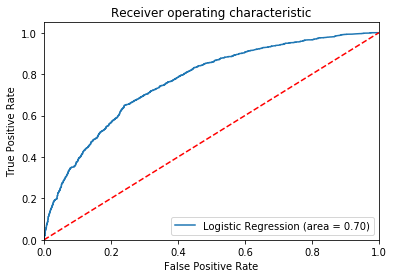

In [120]:
# ROC Curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [121]:
# Average precision-recall
average_precision = average_precision_score(y_test, logreg.predict(X_test))
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.64


In [122]:
# Good and Bad Clients
ID = accepts['ID']
X = accepts.iloc[:,1:14]
preds = pd.DataFrame(logreg.predict(accepts.iloc[:,1:14])).rename(columns={0:'Preds'})

Classification = pd.concat([ID,X,preds],axis=1)

Classification['Preds'][Classification['Preds'] == 0] = 'Good Client'
Classification['Preds'][Classification['Preds'] == 1] = 'Bad Client'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [123]:
print('% of Good Clients:',round((sum(Classification['Preds'] == 'Good Client')/len(Classification['Preds']))*100,2))

% of Good Clients: 44.92


------------------------------------------------------------------------------------------

**f) Other models:**

***Naïve Bayes:***

In [133]:
from sklearn.naive_bayes import GaussianNB

In [134]:
# Training the model
nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB(priors=None)

In [135]:
# Model Accuracy
y_pred = nb.predict(X_test)
print('Accuracy of Naïve Bayes classifier on test set: {:.2f}'.format(nb.score(X_test, y_test)))

Accuracy of Naïve Bayes classifier on test set: 0.66


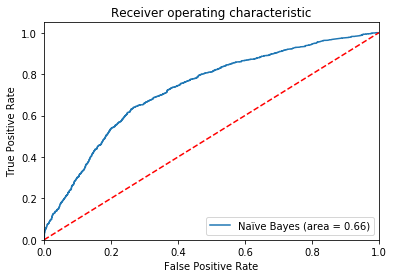

In [136]:
# ROC Curve
nb_roc_auc = roc_auc_score(y_test, nb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, nb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Naïve Bayes (area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [137]:
# Average precision-recall
average_precision = average_precision_score(y_test, nb.predict(X_test))
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.61


***K-Nearest Neighbours:***

In [138]:
from sklearn.neighbors import KNeighborsClassifier

In [139]:
# Training the model
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weights='uniform')

In [140]:
# Model Accuracy
y_pred = knn.predict(X_test)
print('Accuracy of K-Nearest Neighbours classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of K-Nearest Neighbours classifier on test set: 0.70


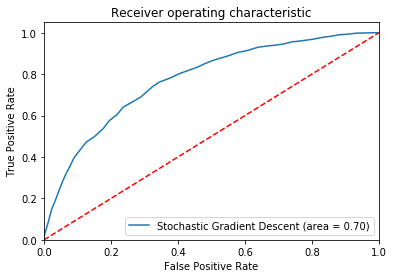

In [141]:
# ROC Curve
knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Stochastic Gradient Descent (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [142]:
# Average precision-recall
average_precision = average_precision_score(y_test, knn.predict(X_test))
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.65


***Random Forest:***

In [143]:
from sklearn.ensemble import RandomForestClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [144]:
# Training the model
rfm = RandomForestClassifier(n_estimators=70,oob_score=True,n_jobs=1,max_features=None,min_samples_leaf=30,random_state=123)
rfm.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

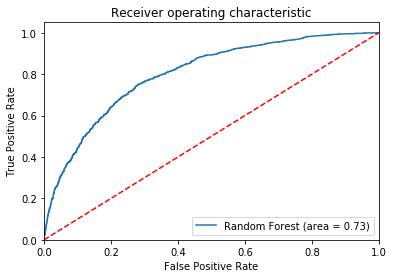

In [145]:
# ROC Curve
rfm_roc_auc = roc_auc_score(y_test, rfm.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfm.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rfm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [146]:
# Average precision-recall
average_precision = average_precision_score(y_test, rfm.predict(X_test))
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.67


The Random Forest was the model with the best AUC score, so this could be used as final model. However, I tend to preffer the Logistic Regression because it is very intuitive and easy to explain in a business enviroment.

------------------------------------------------------------------------------------------

**g) Rejects Database:**

In order to replicate the previous exercise but with the rejects database, we have to transform our variables into continuous. Therefore, we are going to take the WOE metrics obtained in the previous exercise. Once transformed the database, we can use the accepts trained model to estimate a the likelihood of 'being a good or bad client' over the rejected customers.

In [147]:
# Inspecting 'rejects' table
rejects.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio
0,305932,3,3,14,2,1,5,1,1,1,1,-0.030455,-0.323920,-0.605449,-1.064220,1.028210,-0.768631
1,305764,1,4,7,1,6,4,1,2,1,1,0.715222,5.668368,1.299572,0.807662,1.081778,1.796590
2,305971,1,4,10,4,5,4,1,4,1,3,0.764933,-0.750782,0.434027,-0.390342,-0.969416,1.796590
3,305664,1,5,14,2,2,5,3,3,1,1,-1.347818,-0.852651,-0.490122,-0.989344,1.046303,-0.768631
4,305639,1,4,15,1,5,4,1,3,1,2,1.634890,3.200955,0.561380,0.583036,0.088464,1.796590


In [148]:
rejects.shape

(5000, 17)

In [149]:
# Knowing the data type
rejects.dtypes

ID                       int64
V1                       int64
V2                       int64
V3                       int64
V4                       int64
V5                       int64
V6                       int64
V7                       int64
V8                      object
Has_FICO                 int64
Business_channel         int64
FICO_Score             float64
Loan_amount            float64
Monthly_income         float64
Age                    float64
Gearing_coefficient    float64
Max_gearing_ratio      float64
dtype: object

In [150]:
# Convert ID into a string
rejects['ID'] = rejects['ID'].astype('str')

In [151]:
# Convert Vs features into category
for i in rejects.iloc[:,1:11].columns:
    rejects[i] = rejects[i].astype('category')

In [152]:
# Convert Vs features into floats
for i in rejects.iloc[:,11:18].columns:
    rejects[i] = rejects[i].astype('float')

In [153]:
# Detecting NAs values
for i in rejects.columns:
    print(i,':',sum(rejects[i].isna()))

ID : 0
V1 : 0
V2 : 0
V3 : 0
V4 : 0
V5 : 0
V6 : 0
V7 : 0
V8 : 0
Has_FICO : 0
Business_channel : 0
FICO_Score : 2086
Loan_amount : 0
Monthly_income : 0
Age : 0
Gearing_coefficient : 0
Max_gearing_ratio : 0


In [154]:
# Change the NAs values by medians in the FICO_Score feature
rejects['FICO_Score'] = rejects['FICO_Score'].fillna(rejects['FICO_Score'].median())

In [155]:
# Binning Max_gearing_ratio
def func(row):
    if row['Max_gearing_ratio'] < 0:
        return 1
    elif row['Max_gearing_ratio'] < 1.7:
        return 2 
    else:
        return 3

rejects['Max_gearing_ratio_binned'] = rejects.apply(func, axis=1)    
rejects['Max_gearing_ratio_binned'] = rejects['Max_gearing_ratio_binned'].astype('category')

In [156]:
rejects.dtypes

ID                            object
V1                          category
V2                          category
V3                          category
V4                          category
V5                          category
V6                          category
V7                          category
V8                          category
Has_FICO                    category
Business_channel            category
FICO_Score                   float64
Loan_amount                  float64
Monthly_income               float64
Age                          float64
Gearing_coefficient          float64
Max_gearing_ratio            float64
Max_gearing_ratio_binned    category
dtype: object

In [157]:
rejects['Age_binned'] = tree_model_1.predict_proba(rejects['Age'].to_frame())[:,1]
rejects['Age_binned'] = rejects['Age_binned'].astype('category')

rejects['FICO_Score_binned'] = tree_model_2.predict_proba(rejects['FICO_Score'].to_frame())[:,1]
rejects['FICO_Score_binned'] = rejects['FICO_Score_binned'].astype('category')

rejects['Loan_amount_binned'] = tree_model_3.predict_proba(rejects['Loan_amount'].to_frame())[:,1]
rejects['Loan_amount_binned'] = rejects['Loan_amount_binned'].astype('category')

rejects['Monthly_income_binned'] = tree_model_4.predict_proba(rejects['Monthly_income'].to_frame())[:,1]
rejects['Monthly_income_binned'] = rejects['Monthly_income_binned'].astype('category')

rejects['Gearing_coefficient_binned'] = tree_model_5.predict_proba(rejects['Gearing_coefficient'].to_frame())[:,1]
rejects['Gearing_coefficient_binned'] = rejects['Gearing_coefficient_binned'].astype('category')

In [158]:
# Final table 
a1 = rejects.iloc[:,:11]
a2 = rejects.iloc[:,17:]

frames = [a1,a2]
rejects = pd.concat(frames,axis=1)
rejects.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,Max_gearing_ratio_binned,Age_binned,FICO_Score_binned,Loan_amount_binned,Monthly_income_binned,Gearing_coefficient_binned
0,305932,3,3,14,2,1,5,1,1,1,1,1,0.338182,0.065341,0.241163,0.206481,0.269817
1,305764,1,4,7,1,6,4,1,2,1,1,3,0.123350,0.065341,0.241163,0.192308,0.269817
2,305971,1,4,10,4,5,4,1,4,1,3,3,0.276257,0.065341,0.241163,0.260480,0.221184
3,305664,1,5,14,2,2,5,3,3,1,1,1,0.276257,0.514124,0.241163,0.260480,0.269817
4,305639,1,4,15,1,5,4,1,3,1,2,3,0.123350,0.065341,0.241163,0.260480,0.221184


In [159]:
# Every column has to be in upper case in order to join both tables
rejects.columns = rejects.columns.str.upper() 

In [160]:
# Joining all together in order to have a table with continuos variables
rejects1 = rejects.merge(V1_2, on='V1', how='left')
rejects2 = rejects1.merge(V2_2, on='V2', how='left')
rejects3 = rejects2.merge(V3_2, on='V3', how='left')
rejects4 = rejects3.merge(V4_2, on='V4', how='left')
rejects5 = rejects4.merge(V5_2, on='V5', how='left')
rejects6 = rejects5.merge(V6_2, on='V6', how='left')
rejects7 = rejects6.merge(V7_2, on='V7', how='left')
rejects8 = rejects7.merge(V8_2, on='V8', how='left')
rejects9 = rejects8.merge(BUSINESS_CHANNEL_2, on='BUSINESS_CHANNEL', how='left')
rejects10 = rejects9.merge(AGE_BINNED_2, on='AGE_BINNED', how='left')
rejects11 = rejects10.merge(FICO_SCORE_BINNED_2, on='FICO_SCORE_BINNED', how='left')
rejects12 = rejects11.merge(LOAN_AMOUNT_BINNED_2, on='LOAN_AMOUNT_BINNED', how='left')
rejects13 = rejects12.merge(MONTHLY_INCOME_BINNED_2, on='MONTHLY_INCOME_BINNED', how='left')

rejects = rejects13

In [161]:
# Good and Bad Clients
ID = rejects['ID']
X = rejects.iloc[:,17:]
preds = pd.DataFrame(logreg.predict(rejects.iloc[:,17:])).rename(columns={0:'DEFAULT_45'})

Classification_rejects = pd.concat([ID,X,preds],axis=1)
rejects = Classification_rejects
    
#Classification_rejects['Preds'][Classification_rejects['Preds'] == 0] = 'Good Client'
#Classification_rejects['Preds'][Classification_rejects['Preds'] == 1] = 'Bad Client'

In [162]:
Classification_rejects.head()

,ID,V1_WOE,V2_WOE,V3_WOE,V4_WOE,V5_WOE,V6_WOE,V7_WOE,V8_WOE,BUSINESS_CHANNEL_WOE,AGE_BINNED_WOE,FICO_SCORE_BINNED_WOE,LOAN_AMOUNT_BINNED_WOE,MONTHLY_INCOME_BINNED_WOE,DEFAULT_45
0,305932,-0.564496,-0.104869,-0.487602,-0.130021,-0.706269,-0.433480,0.276576,-0.343288,0.176575,-0.539540,1.513059,-0.039704,0.063397,0
1,305764,0.327443,0.293276,0.512072,0.123369,0.801843,0.038751,0.276576,0.299135,0.176575,0.752629,1.513059,-0.039704,0.208163,0
2,305971,0.327443,0.293276,-0.339066,-0.274365,0.409331,0.038751,0.276576,0.074147,1.166735,-0.208180,1.513059,-0.039704,-0.096678,0
3,305664,0.327443,-0.303830,-0.487602,-0.130021,-0.613632,-0.433480,-0.355593,0.223054,0.176575,-0.208180,-1.250837,-0.039704,-0.096678,1
4,305639,0.327443,0.293276,-0.070250,0.123369,0.409331,0.038751,0.276576,0.223054,-0.765888,0.752629,1.513059,-0.039704,-0.096678,0


In [163]:
print('% of Good Clients:',round((sum(Classification_rejects['DEFAULT_45'] == 0)/len(Classification_rejects['DEFAULT_45']))*100,2))

% of Good Clients: 80.98


------------------------------------------------------------------------------------------

**h) Final Model:** 

In [164]:
# Oversampling
X = rejects.iloc[:,:14]
y = rejects['DEFAULT_45']

ros = RandomOverSampler(random_state=123)
X_resampled, y_resampled = ros.fit_sample(X, y)

X_resampled = pd.DataFrame(X_resampled)
y_resampled = pd.DataFrame(y_resampled)

b = pd.concat([X_resampled,y_resampled], axis=1)
b.columns = rejects.columns

rejects = b

In [165]:
# Here I am combining my reject database with the accepts training database
accepts_train = pd.concat([X_train,y_train],axis=1)
accepts_train = accepts_train.reset_index().rename(columns={'index':'ID'})

final = pd.concat([accepts_train,rejects],axis=0)
final.head()

,ID,V1_WOE,V2_WOE,V3_WOE,V4_WOE,V5_WOE,V6_WOE,V7_WOE,V8_WOE,BUSINESS_CHANNEL_WOE,AGE_BINNED_WOE,FICO_SCORE_BINNED_WOE,LOAN_AMOUNT_BINNED_WOE,MONTHLY_INCOME_BINNED_WOE,DEFAULT_45
0,1393.0,-0.564496,-0.104869,-0.487557,-0.185892,-0.613632,-0.433480,0.276576,-0.343288,-0.765888,-0.208180,-0.039518,-0.039704,-0.096678,1
1,13331.0,-0.062751,0.293276,0.350785,0.123369,-0.613632,0.038751,-0.355593,-0.343288,0.176575,-0.208180,-1.250837,-0.039704,-0.096678,1
2,2933.0,0.327443,-0.303830,-0.339066,-0.274365,-0.613632,-0.433480,0.276576,0.223054,-0.765888,-0.208180,-0.698061,-0.039704,-0.096678,1
3,1526.0,0.327443,0.293276,-0.339066,-0.274365,0.316158,-0.433480,0.276576,0.299135,1.166735,0.752629,-0.039518,1.257677,0.063397,0
4,13295.0,-0.564496,-0.303830,-0.109900,-0.130021,-0.706269,-0.433480,-0.355593,-0.343288,0.176575,-0.208180,-0.039518,-0.039704,-0.096678,1


In [168]:
# Splitting the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(final.iloc[:,1:14],final['DEFAULT_45'] , test_size = 0.3)

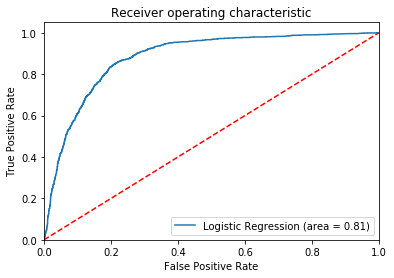

In [169]:
# Training the model
logreg = LogisticRegression(random_state=123)
logreg.fit(X_train, y_train)

# ROC Curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

By doing this, now my model is giving me back an AUC of 81%, around 10 pp higher than the previous model.

***Scorecard using Logistic Regression:***

In [170]:
print('Coefficients:',logreg.fit(X_train, y_train).coef_)
print('Intercept:',logreg.fit(X_train, y_train).intercept_)

Coefficients: [[-0.28405416 -1.18768438 -0.40086023  0.29759231 -0.73066642 -0.19888157
  -0.14639828 -0.39771959 -1.1951206  -0.01071842 -1.64448054  0.38705425
   0.21514388]]
Intercept: [0.07746709]


In [171]:
# Coefficients and intercept
coef = np.array(logreg.fit(X_train, y_train).coef_)
intercept = np.array(logreg.fit(X_train, y_train).intercept_)

In [172]:
# Creating the Score table
score = pd.DataFrame(accepts['ID'])
score['V1_Score'] = pd.DataFrame((((-accepts['V1_WOE']*coef[0][0])+(intercept[0]/13))*Factor)+(Offset/13))
score['V2_Score'] = pd.DataFrame((((-accepts['V2_WOE']*coef[0][1])+(intercept[0]/13))*Factor)+(Offset/13))
score['V3_Score'] = pd.DataFrame((((-accepts['V3_WOE']*coef[0][2])+(intercept[0]/13))*Factor)+(Offset/13))
score['V4_Score'] = pd.DataFrame((((-accepts['V4_WOE']*coef[0][3])+(intercept[0]/13))*Factor)+(Offset/13))
score['V5_Score'] = pd.DataFrame((((-accepts['V5_WOE']*coef[0][4])+(intercept[0]/13))*Factor)+(Offset/13))
score['V6_Score'] = pd.DataFrame((((-accepts['V6_WOE']*coef[0][5])+(intercept[0]/13))*Factor)+(Offset/13))
score['V7_Score'] = pd.DataFrame((((-accepts['V7_WOE']*coef[0][6])+(intercept[0]/13))*Factor)+(Offset/13))
score['V8_Score'] = pd.DataFrame((((-accepts['V8_WOE']*coef[0][7])+(intercept[0]/13))*Factor)+(Offset/13))
score['BUSINESS_CHANNEL_Score'] = pd.DataFrame((((-accepts['BUSINESS_CHANNEL_WOE']*coef[0][8])+(intercept[0]/13))*Factor)+(Offset/13))
score['AGE_Score'] = pd.DataFrame((((-accepts['AGE_BINNED_WOE']*coef[0][9])+(intercept[0]/13))*Factor)+(Offset/13))
score['FICO_Score'] = pd.DataFrame((((-accepts['FICO_SCORE_BINNED_WOE']*coef[0][10])+(intercept[0]/13))*Factor)+(Offset/13))
score['LOAN_AMOUNT_Score'] = pd.DataFrame((((-accepts['LOAN_AMOUNT_BINNED_WOE']*coef[0][11])+(intercept[0]/13))*Factor)+(Offset/13))
score['MONTHLY_INCOME_Score'] = pd.DataFrame((((-accepts['MONTHLY_INCOME_BINNED_WOE']*coef[0][12])+(intercept[0]/13))*Factor)+(Offset/13))

#score['Total_Score'] = ((score.iloc[:,1:].sum(axis=1))*Factor)+(Offset)
score['Total_Score'] = score.iloc[:,1:].sum(axis=1)

In [173]:
score.head()

,ID,V1_Score,V2_Score,V3_Score,V4_Score,V5_Score,V6_Score,V7_Score,V8_Score,BUSINESS_CHANNEL_Score,AGE_Score,FICO_Score,LOAN_AMOUNT_Score,MONTHLY_INCOME_Score,Total_Score
0,250263.0,44.257128,51.392437,44.943911,39.456272,51.367712,45.363459,43.499408,44.631660,45.959758,43.031639,41.977702,43.136966,43.215333,582.233385
1,250290.0,44.257128,52.986018,41.844602,44.093200,47.230134,44.414769,43.499408,44.631660,45.959758,43.031639,78.812327,43.136966,43.215333,617.112941
2,250249.0,44.512882,41.118366,44.943911,39.456272,51.478665,45.363459,43.499408,44.631660,45.959758,43.031639,41.977702,43.136966,41.279687,570.390374
3,249516.0,40.601930,41.118366,40.954371,44.093200,36.446783,43.026444,43.499408,44.631660,45.959758,43.031639,41.977702,43.136966,43.215333,551.693559
4,249827.0,44.257128,41.118366,49.005565,43.473483,46.247965,43.026444,43.499408,44.195116,45.959758,42.883065,41.977702,43.136966,42.718482,571.499447


In [174]:
score['Total_Score'].max()

644.0133506497017

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


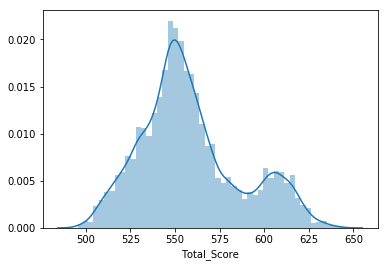

In [175]:
# Analysing Date_Late
sns.distplot(score['Total_Score'])

In [176]:
(sum(score['Total_Score'] > 600)/len(score['Total_Score']))*100

12.82084861183866

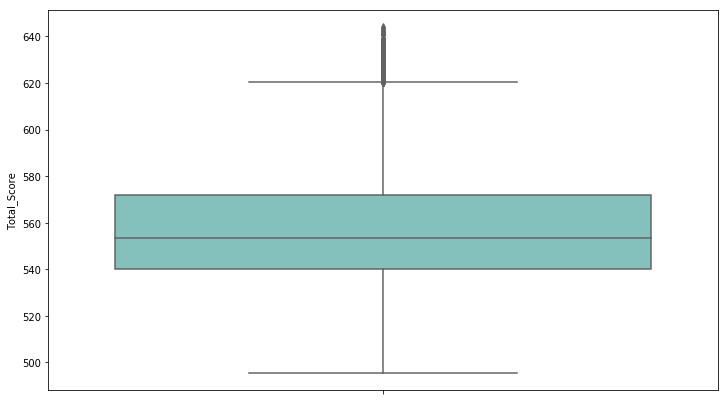

In [177]:
# Analysing Date_Late
ax1 = plt.subplots(1, 1, figsize=(12, 7), sharex=True)
ax1 = sns.boxplot(y='Total_Score', data=score, palette="GnBu", showfliers = True)

**Conclusions:** Around the 12.8% of all the base would have access to a credit (using the establablished Factor and Offset). 